[View in Colaboratory](https://colab.research.google.com/github/mari-linhares/tensorflow-brasil/blob/eager-hub/classificador_caes_e_gatos_eager.ipynb)

# Classificador de Imagens usando TensorFlow

Neste notebook iremos implementar um modelo para classificação de imagens. Classificação é uma dos casos de uso de Machine Learning, nesta tarefa o ensino é supervisionado, em outras palavras nós vamos ensinar ao modelo através de exemplos com gabarito.

Nosso modelo deverá receber imagens de gatos e cachorros e identificar a que classe (gato ou cachorro) estas imagens pertencem.

## Dados
Os dados foram retirados da base de dados CIFAR 10 que contém 10000 imagens de 10 classes distintas, para este exemplo iremos utilizar apenas as classes gato e cachorro.

## Modelo
Iremos utilizar diferentes modelos com diferentes níveis de complexidade.

## Créditos

Essa atividade é baseada em vários trabalhos já existentes e adaptados, alguns desses materiais são:
* no notebook encontrado aqui implementada originalmente por @chrisying.
* Colab sobre TensorFlow Hub por [Damien Pontifex](https://colab.research.google.com/github/damienpontifex/BlogCodeSamples/blob/master/TransferLearning/TfHubDogsVsCats.ipynb#scrollTo=bgYkTngWfKrG)
* Palestra sobre Eager mode e High Level APIs no Google I/O

Obrigada a todos os envolvidos!

## Dependências

### Instalando TensorFlow 1.8.0

Esse tutorial usa TensorFlow Eager mode, que está apenas disponível a partir do TensorFlow 1.8 **Após executar o código abaixo você precisa reiniciar o Runtime ou Kernel (Jupyter notebook)**.

In [19]:
!pip install --upgrade --force tensorflow==1.8.0

    100% |████████████████████████████████| 49.1MB 584kB/s 
    100% |████████████████████████████████| 8.7MB 6.3MB/s 
    100% |████████████████████████████████| 61kB 20.3MB/s 
    100% |████████████████████████████████| 6.4MB 7.6MB/s 
    100% |████████████████████████████████| 51kB 5.5MB/s 
    100% |████████████████████████████████| 92kB 19.6MB/s 
    100% |████████████████████████████████| 3.1MB 9.0MB/s 
    100% |████████████████████████████████| 12.1MB 2.4MB/s 
    100% |████████████████████████████████| 102kB 11.1MB/s 


    100% |████████████████████████████████| 573kB 18.9MB/s 
    100% |████████████████████████████████| 890kB 18.6MB/s 
    100% |████████████████████████████████| 327kB 19.5MB/s 
    100% |████████████████████████████████| 81kB 21.5MB/s 
  Running setup.py bdist_wheel for gast ... - done
  Stored in directory: /content/.cache/pip/wheels/9a/1f/0e/3cde98113222b853e98fc0a8e9924480a3e25f1b4008cedb4f
  Running setup.py bdist_wheel for absl-py ... - done
  Stored in directory: /content/.cache/pip/wheels/23/35/1d/48c0a173ca38690dd8dfccfa47ffc750db48f8989ed898455c
  Running setup.py bdist_wheel for termcolor ... - done
  Stored in directory: /content/.cache/pip/wheels/7c/06/54/bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Running setup.py bdist_wheel for html5lib ... - done
  Stored in directory: /content/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built gast absl-py termcolor html5lib
  Found existing installation: enum34 1.1.6
  

      Successfully uninstalled numpy-1.14.3
  Found existing installation: Werkzeug 0.14.1
    Uninstalling Werkzeug-0.14.1:
      Successfully uninstalled Werkzeug-0.14.1
  Found existing installation: Markdown 2.6.11
    Uninstalling Markdown-2.6.11:
      Successfully uninstalled Markdown-2.6.11
  Found existing installation: tensorboard 1.7.0
    Uninstalling tensorboard-1.7.0:
      Successfully uninstalled tensorboard-1.7.0
  Found existing installation: termcolor 1.1.0
    Uninstalling termcolor-1.1.0:
      Successfully uninstalled termcolor-1.1.0
  Found existing installation: astor 0.6.2
    Uninstalling astor-0.6.2:
      Successfully uninstalled astor-0.6.2
  Found existing installation: tensorflow 1.7.0
    Uninstalling tensorflow-1.7.0:
      Successfully uninstalled tensorflow-1.7.0
    100% |████████████████████████████████| 61kB 3.9MB/s 


#### Importando TensorFlow

Se a GPU do Colab estiver disponível você deve ver algo do tipo: **/device:GPU:0** na saída abaixo:

In [1]:
import tensorflow as tf
# tf.enable_eager_execution()

import tensorflow.contrib.eager as tfe
tf.test.gpu_device_name()

''

### Instalando demais dependências

In [15]:
 !pip install pillow matplotlib numpy pandas

#### Importando dependências

In [2]:
# Compatibilidade entre Python 2 e Python 3
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os
try:
  import urllib.request as urrlib_request # Python 3
except:
  import urllib as urllib_request  # Python 2
import tarfile
import zipfile


# TensorFlow
tf.logging.set_verbosity(tf.logging.INFO)  # Permitindo visualização de logs

# Bibliotecas auxiliares
try:
  import cPickle  # maior eficiência ao processar as imagens
except:
  import _pickle as cPickle

import numpy as np  # manipular vetores
from PIL import Image  # lidar com imagens
import matplotlib.pyplot as plt  # plotar imagens
%matplotlib inline

import glob  # lidar com arquivos

# IMPORTANTE: essa linha garante que os números gerados aleatoriamente são previsíveis
np.random.seed(0)


tf.logging.info('Recomenda-se para esta atividade uma versão >= 1.8.0')
tf.logging.info('Sua versão do TensorFlow {}'.format(tf.__version__))
tf.logging.info('GPU disponível? {}'.format('Sim' if tf.test.is_gpu_available() else 'Não'))

%matplotlib inline

INFO:tensorflow:Recomenda-se para esta atividade uma versão >= 1.8.0
INFO:tensorflow:Sua versão do TensorFlow 1.8.0
INFO:tensorflow:GPU disponível? Não


## Buscando e tratando os dados

Pode ignorar essa parte do código caso seu foco seja apenas aprender mais sobre TensorFlow especificamente. Aqui o que é feito é:
* Os dados são baixados caso necessário.
* As imagens são tratadas: shapes corrigidas, valores normalizados...


### Baixando os dados

O código abaixo foi basicamente copiado diretamente de: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/download.py pois esse não é o foco desse tutorial.

In [0]:
def _print_download_progress(count, block_size, total_size):
  """
  Function used for printing the download progress.
  Used as a call-back function in maybe_download_and_extract().
  """

  # Percentage completion.
  pct_complete = float(count * block_size) / total_size

  # Status-message. Note the \r which means the line should overwrite itself.
  msg = "\r- Download progress: {0:.1%}".format(pct_complete)

  # Print it.
  sys.stdout.write(msg)
  sys.stdout.flush()


def maybe_download_and_extract(url="https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz",
                               download_dir="."):
  """
  Download and extract the data if it doesn't already exist.
  Assumes the url is a tar-ball file.
  :param url:
      Internet URL for the tar-file to download.
      Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
  :param download_dir:
      Directory where the downloaded file is saved.
      Example: "data/CIFAR-10/"
  :return:
      Nothing.
  """

  # Filename for saving the file downloaded from the internet.
  # Use the filename from the URL and add it to the download_dir.
  filename = url.split('/')[-1]
  file_path = os.path.join(download_dir, filename)

  # Check if the file already exists.
  # If it exists then we assume it has also been extracted,
  # otherwise we need to download and extract it now.
  if not os.path.exists(file_path):
      # Check if the download directory exists, otherwise create it.
      if not os.path.exists(download_dir):
          os.makedirs(download_dir)

      # Download the file from the internet.
      file_path, _ = urllib_request.urlretrieve(url=url,
                                                filename=file_path,
                                                reporthook=_print_download_progress)

      print()
      print("Download finished. Extracting files.")

      if file_path.endswith(".zip"):
          # Unpack the zip-file.
          zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
      elif file_path.endswith((".tar.gz", ".tgz")):
          # Unpack the tar-ball.
          tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

      print("Done.")
  else:
      print("Data has apparently already been downloaded and unpacked.")


In [4]:
maybe_download_and_extract(url='http://files.fast.ai/data/dogscats.zip')

Data has apparently already been downloaded and unpacked.


In [4]:
!ls  # checando se a nova pasta foi criada
!ls 'dogscats/'  # checando o que tem dentro dela
DATA_DIR = 'dogscats/'  # "apontando" para nova pasta

datalab  dogscats  dogscats.zip
models	sample	test1  train  valid


#### Visualizando algumas imagens do dataset e seus labels

In [6]:
# Temos cada imagem individualmente
gatos = glob.glob(os.path.join(DATA_DIR, 'train', 'cats', '*'))[:5]
gatos

['dogscats/train/cats/cat.8792.jpg',
 'dogscats/train/cats/cat.9392.jpg',
 'dogscats/train/cats/cat.10802.jpg',
 'dogscats/train/cats/cat.11418.jpg',
 'dogscats/train/cats/cat.1128.jpg']

Exemplo de 6 imagens da base de treino
11500 11500


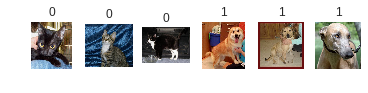

In [7]:
def visualizar_dados_treino(num_imgs_por_classe, data_dir):
    '''Essa função apresenta alguns dados de treino (imagens, labels) escolhidos aleatoriamente.
       Parâmetros:
           num_imgs_por_classe (int): número de imagens apresentadas por classe.
           data_dir (string): onde os arquivos foram baixados.
    '''

    print('Exemplo de %d imagens da base de treino' % (num_imgs_por_classe * 2))
    
    # Obtemos as imagens
    treino_path = os.path.join(data_dir, 'train')
    gatos = os.listdir(os.path.join(treino_path, 'cats'))
    caes = os.listdir(os.path.join(treino_path, 'dogs'))
    
    # Escolhemos índices aleatórios
    print(len(gatos), len(caes))
    random_ind_gato = np.random.choice(len(gatos), num_imgs_por_classe, replace=False)
    random_ind_cao = np.random.choice(len(caes), num_imgs_por_classe, replace=False)
    
    # Buscando imagens e labels
    imagens = [gatos[r] for r in random_ind_gato] + [caes[r] for r in random_ind_cao]
    labels = [0] * num_imgs_por_classe + [1] * num_imgs_por_classe
    
    # Plottando imagens
    for index, (img, label) in enumerate(zip(imagens, labels)):
        if 'cat' in img:
          path = os.path.join(treino_path, 'cats')
        else:
          path = os.path.join(treino_path, 'dogs')
        
        img = plt.imread(os.path.join(path, img))
        
        plt.subplot(4, num_imgs_por_classe * 2, index + 1)
        plt.axis('off')
        plt.imshow(img, cmap=plt.cm.gray_r)
        plt.title('%i' % label)
    plt.show()

visualizar_dados_treino(3, DATA_DIR)

As imagens são maiores do que parecem! Abaixo temos um exemplo de uma única imagem.

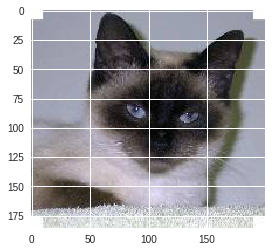

In [8]:
img = plt.imread(gatos[0])
plt.imshow(img)

### Usando Tf.data para lidar com os dados!

Tf.data é uma api fléxivel e rápida que permite manipular desde uma pequena quantidade de dados até dados que não cabem na memória. 

In [0]:
def _img_string_to_tensor(image_string, image_size=(299, 299)):
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    # Convert from full range of uint8 to range [0,1] of float32.
    image_decoded_as_float = tf.image.convert_image_dtype(image_decoded, dtype=tf.float32)
    # Resize to expected
    image_resized = tf.image.resize_images(image_decoded_as_float, size=image_size)
    
    return image_resized

def get_dataset(file_pattern, image_size=(224, 224), shuffle=False,
                batch_size=64, num_epochs=None, buffer_size=4096):
    def _path_to_img(path):
        # Get the parent folder of this file to get it's class name
        label = tf.string_split([path], delimiter='/').values[-2]
        # Read in the image from disk
        image_string = tf.read_file(path)
        image_resized = _img_string_to_tensor(image_string, image_size)
        
        return image_resized, label

    dataset = tf.data.Dataset.list_files(file_pattern)

    if shuffle:
        dataset = dataset.apply(tf.contrib.data.shuffle_and_repeat(buffer_size, num_epochs))
    else:
        dataset = dataset.repeat(num_epochs)

    dataset = dataset.map(_path_to_img)
    dataset = dataset.batch(batch_size).prefetch(buffer_size)

    return dataset

In [16]:
# o filtro .8 é apenas para diminuir o tamanho do treino para treinar mais rápido
train_files = os.path.join(DATA_DIR, 'train', '**/*.8.jpg')
test_files = os.path.join(DATA_DIR, 'valid', '**/*8.jpg')
print(len(glob.glob(test_files)))
train_ds = get_dataset(train_files, batch_size=32, shuffle=True, image_size=(32, 32))
test_ds = get_dataset(test_files, batch_size=32)

197


### Verificando se dados foram salvos corretamente

Após manipular ou modificar os dados é sempre importante garantir que os dados estão no formato esperado e não foram corrompidos ou alterados indevidamente. Para isto vamos escolher algumas imagens do conjunto de treino aleatoriamente e verificá-las.

> IMPORTANTE: para modelos reais é importante garantir a qualidade e integridade dos dados com maior rigor já que é fundamental a "saúde" dos dados para se obter um bom modelo.

## Implementando os modelos!

Iremos implementar 4 diferentes abordagens para o nosso problema:
* Rede neural com Keras
* Árvore de decisão com Estimators
* Rede neural convolucional com Keras
* Transfer learning com Tf.hub

### Rede neural com Keras

In [0]:
H = 32
W = 32

BATCH_SIZE = 128


def str_to_idx(y):
  return [1 if aux.numpy() == 'cats' else 0 for aux in y]


In [0]:
FLAT_DIM = H * W * 3


def get_dataset_old(imagens, labels, batch_size=100, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((imagens, labels))\
       .map(lambda x, y: ((tf.cast(x, tf.float32)/ 255.0) - 1.0, tf.cast(y, tf.int32)))
  
  if shuffle:
    ds = ds.shuffle(buffer_size=1000)
  
  if batch_size is not None:
    ds = ds.batch(batch_size)
    
  return ds

def flat_x(x, batch_size=BATCH_SIZE):
  batch_size = min(batch_size, x.shape[0])
  return tf.reshape(x, (batch_size, FLAT_DIM))

model = tf.keras.Sequential([
  tf.keras.layers.Dense(FLAT_DIM, activation="relu", input_shape=(BATCH_SIZE, FLAT_DIM)),  # input shape required
  tf.keras.layers.Dense(128, activation="relu"),
  tf.keras.layers.Dense(2)
])

def loss(model, x, y):
  y_ = model(x)
  return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)


def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, model.variables)

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

train_files = os.path.join(DATA_DIR, 'train', '**/*8*.jpg')
test_files = os.path.join(DATA_DIR, 'valid', '**/*8*.jpg')

num_epochs = 5

# keep results for plotting
train_loss_results = []
train_accuracy_results = []


train_ds = get_dataset(train_files, batch_size=BATCH_SIZE, shuffle=True, image_size=(H, W), num_epochs=1)
test_ds = get_dataset(test_files, batch_size=BATCH_SIZE, image_size=(H, W), num_epochs=1)

In [0]:

for epoch in range(num_epochs):
  
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    for i, (x, y) in enumerate(train_ds):
      # Optimize the model
      x = flat_x(x)
      y = str_to_idx(y)

      # y = [1 if aux == 'cats' else 0 for aux in y]
      grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.variables),
                                global_step=tf.train.get_or_create_global_step())

      # Track progress
      l = loss(model, x, y)
      output = model(x)
      
      epoch_loss_avg(l)  # add current batch loss
      # compare predicted label to actual label
      epoch_accuracy(tf.argmax(output, axis=1, output_type=tf.int32), y)
      
      if i % 10 == 0:
        print('Train epoch %d, step %d, Loss: %.4f' % (epoch, i, l))

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
      
    # model_test_output = softmax_model(dados_teste['imagens'])
    # model_test_label = dados_treino['labels']
    # correct_prediction = tf.equal(tf.argmax(model_test_output, 1), tf.argmax(model_test_label, 1))
    # accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    test_accuracy = tfe.metrics.Accuracy()

    for (x, y) in test_ds:
      x = flat_x(x)
      y = str_to_idx(y)
      prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
      test_accuracy(prediction, y)

    print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
    print("Epoch {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

### Rede Neural Convolucional com Keras

In [17]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(H, W, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),  
  tf.keras.layers.Conv2D(64, 3, activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(2)
])

optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

num_epochs = 20

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

    for i, (x, y) in enumerate(train_ds):
      # Optimize the model
      y = str_to_idx(y)
      grads = grad(model, x, y)
      optimizer.apply_gradients(zip(grads, model.variables),
                                global_step=tf.train.get_or_create_global_step())

      # Track progress
      l = loss(model, x, y)
      output = model(x)
      
      epoch_loss_avg(l)  # add current batch loss
      # compare predicted label to actual label
      epoch_accuracy(tf.argmax(output, axis=1, output_type=tf.int32), y)
      
      if i % 10 == 0:
        print('Train epoch %d, step %d, Loss: %.4f' % (epoch, i, l))


    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
      
    # model_test_output = softmax_model(dados_teste['imagens'])
    # model_test_label = dados_treino['labels']
    # correct_prediction = tf.equal(tf.argmax(model_test_output, 1), tf.argmax(model_test_label, 1))
    # accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    test_accuracy = tfe.metrics.Accuracy()

    for (x, y) in test_ds:
      y = str_to_idx(y)
      prediction = tf.argmax(model(x), axis=1, output_type=tf.int32)
      test_accuracy(prediction, y)

    print("Test set accuracy: {:.3%}".format(test_accuracy.result()))
    print("Epoch {:03d}: Train Loss: {:.3f}, Train Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Train epoch 0, step 0, Loss: 0.6866


KeyboardInterrupt: ignored

### Transfer Learning com TensorFlow Hub

In [0]:
import tensorflow_hub as hub

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/cell_0/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/1x1/weights
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/beginning_bn/beta
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/beginning_bn/gamma
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/beginning_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_0/beginning_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78f

INFO:tensorflow:Initialize variable module/cell_0/comb_iter_0/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_0/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/bn_sep_5x5_1/beta
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_1/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_1/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize var

INFO:tensorflow:Initialize variable module/cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_4/left/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_4/left/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_0/comb_iter_4/left/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_0/comb_iter_4/left/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_1/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_0/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_0/l

INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/left/separable_5x5_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_1/comb_iter_1/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/comb_iter_1/right/bn_sep_3x3_1/gamma
INFO:tenso

INFO:tensorflow:Initialize variable module/cell_1/prev_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/beta
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/gamma
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_1/prev_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_1/prev_bn/moving_variance
INFO:tensorflow:Initialize variable module/cell_10/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/1x1/weights
INFO:tensorflow:Initialize varia

INFO:tensorflow:Initialize variable module/cell_10/comb_iter_0/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_0/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_0/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_0/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_0/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_0/right/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_0/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables w

INFO:tensorflow:Initialize variable module/cell_10/comb_iter_1/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_1/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_4/left/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_4/left/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_4/left/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_10/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_10/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initia

INFO:tensorflow:Initialize variable module/cell_11/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_0/left/separable_5x5_1/depthwise_weights
IN

INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_1/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_1/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_1/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_11/comb_iter_1/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cel

INFO:tensorflow:Initialize variable module/cell_11/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/comb_iter_4/left/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_11/prev_1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/prev_1x1/weights
INFO:tensorflow:Initialize variable module/cell_11/prev_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/prev_bn/beta
INFO:tensorflow:Initialize variable module/cell_11/prev_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_11/prev_bn/gamma
INFO:tensorflow:Initialize variable module/cell_11/prev_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/var

INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_0/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_0/righ

INFO:tensorflow:Initialize variable module/cell_12/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_1/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_1/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_1/right/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_1/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_iter_1/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_12/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_12/comb_

INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_13/comb_iter_1/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_1/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_1/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_1/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_1/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_1/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_1/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_1/left/separable_5x5_1/depthwise_weights
IN

INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_13/comb_iter_4/left/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_13/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cel

INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_0/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_0/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_14/comb_iter_1/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_1/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_1/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_1/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_1/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_1/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_14/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_14/comb_iter_1/righ

INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/left/bn_sep_5x5_1/beta
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_15/comb_iter_1/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_1/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_1/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_1/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_1/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_1/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_1/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_1/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_15/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_15/comb_iter_4/left/separa

INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_0/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_16/comb_iter_1/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_16/comb_iter_1/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_17/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/beginning_bn/beta
INFO:tensorflow:Initialize variable module/cell_17/beginning_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/beginning_bn/gamma
INFO:tensorflow:Initialize variable module/cell_17/beginning_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/beginning_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_17/beginning_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/beginning_bn/moving_variance
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_0/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variab

INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/left/bn_sep_5x5_1/beta
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_1/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_1/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_17/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_4/left/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_4/left/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_4/left/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_4/left/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_17/comb_iter_4/left/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_17/comb_iter_4/left/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/left/separable_5x5_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_0/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_0/right/

INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_2/comb_iter_1/right/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/comb_iter_1/right/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_2/prev_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_2/prev_bn/moving_variance
INFO:tensorflow:Initialize variable module/cell_3/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/1x1/weights
INFO:tensorflow:Initialize variable module/cell_3/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/beginning_bn/beta
INFO:tensorflow:Initialize variable module/cell_3/beginning_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/beginning_bn/gamma
INFO:tensorflow:Initialize variable module/cell_3/beginning_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/beginning_bn/moving_mean
INFO

INFO:tensorflow:Initialize variable module/cell_3/comb_iter_0/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_0/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/left/bn_sep_5x5_1/beta
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_1/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_1/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize var

INFO:tensorflow:Initialize variable module/cell_3/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_4/left/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_4/left/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_3/comb_iter_4/left/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_3/comb_iter_4/left/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_0/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_0/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/com

INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/left/separable_5x5_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_4/comb_iter_1/right/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/comb_iter_1/right/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize

INFO:tensorflow:Initialize variable module/cell_4/prev_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/prev_bn/gamma
INFO:tensorflow:Initialize variable module/cell_4/prev_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/prev_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_4/prev_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_4/prev_bn/moving_variance
INFO:tensorflow:Initialize variable module/cell_5/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/1x1/weights
INFO:tensorflow:Initialize variable module/cell_5/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/beginning_bn/beta
INFO:tensorflow:Initiali

INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/right/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_0/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_0/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_1/left/bn_sep_5x5_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_1/l

INFO:tensorflow:Initialize variable module/cell_5/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_4/left/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_4/left/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_4/left/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_5/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_5/comb_iter_4/left/bn_sep_3x3_1/moving_variance
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_0/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_0/left/separable_5x5_

INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/left/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/left/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/left/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/left/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/left/separable_5x5_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_6/comb_iter_1/right/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/comb_iter_1/right/

INFO:tensorflow:Initialize variable module/cell_6/final_path_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/final_path_bn/beta
INFO:tensorflow:Initialize variable module/cell_6/final_path_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/final_path_bn/gamma
INFO:tensorflow:Initialize variable module/cell_6/final_path_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/final_path_bn/moving_mean
INFO:tensorflow:Initialize variable module/cell_6/final_path_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_6/final_path_bn/moving_variance
INFO:tensorflow:Initialize variable module/cell_6/path1_conv/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables wit

INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_0/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_0/right/separa

INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_1/right/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_1/right/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_7/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_7/comb_iter_4/l

INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_2/beta
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module

INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/left/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_1/left/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_1/left/separable_5x5_

INFO:tensorflow:Initialize variable module/cell_8/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_4/left/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_4/left/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_8/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/comb_iter_4/left/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_8/prev_1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_8/prev_1x1/weights
INFO:tensorflow:Init

INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/right/bn_sep_3x3_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/right/bn_sep_3x3_2/beta
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/right/bn_sep_3x3_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/right/bn_sep_3x3_2/gamma
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/right/bn_sep_3x3_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/right/bn_sep_3x3_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_0/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_0/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variabl

INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_iter_1/right/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_9/comb_iter_1/right/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_9/comb_i

INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/gamma
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_mean
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_1/moving_variance
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_0/left/bn_sep_5x5_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_0/left/bn_sep_5x5_2/beta
IN

INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/beta
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/gamma
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_1/right/bn_sep_7x7_2/moving_var

INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_4/left/bn_sep_3x3_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_4/left/bn_sep_3x3_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_4/left/separable_3x3_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_4/left/separable_3x3_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_0/comb_iter_4/left/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_0/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/

INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/right/bn_sep_7x7_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/right/bn_sep_7x7_2/gamma
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/right/bn_sep_7x7_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/right/bn_sep_7x7_2/moving_mean
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/right/bn_sep_7x7_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/right/bn_sep_7x7_2/moving_variance
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_0/right/separable_7x7_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_0/ri

INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_2/right/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_2/right/separable_5x5_1/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_2/right/separable_5x5_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_2/right/separable_5x5_1/pointwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_2/right/separable_5x5_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with cell_stem_1/comb_iter_2/right/separable_5x5_2/depthwise_weights
INFO:tensorflow:Initialize variable module/cell_stem_1/comb_iter_2/right/separable_5x5_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f

INFO:tensorflow:Initialize variable module/reduction_cell_0/1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/1x1/weights
INFO:tensorflow:Initialize variable module/reduction_cell_0/beginning_bn/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/beginning_bn/beta
INFO:tensorflow:Initialize variable module/reduction_cell_0/beginning_bn/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/beginning_bn/gamma
INFO:tensorflow:Initialize variable module/reduction_cell_0/beginning_bn/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/beginning_bn/moving_mean
INFO:tensorflow:Initialize variable module/reduction_cell_0/beginning_bn/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a

INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_0/right/separable_7x7_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_0/right/separable_7x7_2/depthwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_0/right/separable_7x7_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_0/right/separable_7x7_2/pointwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/beta
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_1/right/bn_sep_7x7_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/varia

INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/beta:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/beta
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/gamma
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_mean
INFO:tensorflow:Initialize variable module/reduction_cell_0/comb_iter_4/left/bn_sep_3x3_1/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_0/comb_ite

INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/left/bn_sep_5x5_2/gamma:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_0/left/bn_sep_5x5_2/gamma
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/left/bn_sep_5x5_2/moving_mean:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_0/left/bn_sep_5x5_2/moving_mean
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/left/bn_sep_5x5_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_0/left/bn_sep_5x5_2/moving_variance
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_0/left/separable_5x5_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables wit

INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_1/right/bn_sep_7x7_2/moving_variance:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_1/right/bn_sep_7x7_2/moving_variance
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_1/right/separable_7x7_1/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_1/right/separable_7x7_1/depthwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_1/right/separable_7x7_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_1/right/separable_7x7_1/pointwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_1/right/separable_7x7_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b0

INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/separable_3x3_1/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_4/left/separable_3x3_1/pointwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/separable_3x3_2/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_4/left/separable_3x3_2/depthwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_1/comb_iter_4/left/separable_3x3_2/pointwise_weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff/variables/variables with reduction_cell_1/comb_iter_4/left/separable_3x3_2/pointwise_weights
INFO:tensorflow:Initialize variable module/reduction_cell_1/prev_1x1/weights:0 from checkpoint /tmp/tfhub_modules/77e12a4b00ee2743f22a9dd90b9d66aa8f78faff

In [10]:
import os
data_directory = 'dogscats/'
params = {
  'module_spec': 'https://tfhub.dev/google/imagenet/mobilenet_v2_035_224/feature_vector/1',
  'module_name': 'resnet_v2_502',
  'train_module': False  # Whether we want to finetune the module
}
m = hub.Module(params['module_spec'], name=params['module_name'])
input_img_size = hub.get_expected_image_size(m)

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/Conv/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/Conv/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/gamma
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/Conv/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/Conv/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/Conv/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/Conv/weights:0 from checkpoint /

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_1/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_1/expand/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_1/expand/weights
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_1/project/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_1/project/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_1/project/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_11/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_11/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_11/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_11/expand/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with Mobi

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_13/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_13/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_13/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_13/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_14/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_14/project/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_14/project/weights
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_15/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_15/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with Mobilenet

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_16/project/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16/project/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_16/project/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16/project/BatchNorm/gamma
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_16/project/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_16/project/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables wi

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/expand/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_3/expand/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_3/expand/weights
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_3/project/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/exp

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_5/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_5/depthwise/depthwise_weights
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_5/expand/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_5/expand/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_5/expand/BatchNorm/gamma
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_5/expand/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expan

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/gamma
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_mean
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_7/depthwise/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_7/depthwise/depthwise_weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/v

INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_8/project/BatchNorm/moving_variance
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_8/project/weights:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_8/project/weights
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expanded_conv_9/depthwise/BatchNorm/beta
INFO:tensorflow:Initialize variable resnet_v2_502/MobilenetV2/expanded_conv_9/depthwise/BatchNorm/gamma:0 from checkpoint /tmp/tfhub_modules/25da67c244c5f4a57c79d6be4239c7d7ce141a3c/variables/variables with MobilenetV2/expa

In [0]:
train_files = os.path.join(data_directory, 'train', '**/*.jpg')
train_input_fn = get_dataset(train_files, image_size=input_img_size, batch_size=8, shuffle=True)

In [15]:
features = module(train_input_fn)
logits = tf.layers.dense(features, NUM_CLASSES)
probabilities = tf.nn.softmax(logits)

TypeError: ignored

In [0]:
def model_fn(features, labels, mode, params):
    is_training = mode == tf.estimator.ModeKeys.TRAIN

    NUM_CLASSES = len(params['label_vocab'])

    module = hub.Module(params['module_spec'], trainable=is_training and params['train_module'], name=params['module_name'])
    bottleneck_tensor = module(features['image'])

    with tf.name_scope('final_retrain_ops'):
        logits = tf.layers.dense(bottleneck_tensor, units=1, trainable=is_training)

    def train_op_fn(loss):
        optimizer = tf.train.AdamOptimizer(learning_rate=params['learning_rate'])
        return optimizer.minimize(loss, global_step=tf.train.get_global_step())

    if NUM_CLASSES == 2:
        head = tf.contrib.estimator.binary_classification_head(label_vocabulary=params['label_vocab'])
    else:
        head = tf.contrib.estimator.multi_class_head(n_classes=NUM_CLASSES, label_vocabulary=params['label_vocab'])

    return head.create_estimator_spec(
        features, mode, logits, labels, train_op_fn=train_op_fn
    )